In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from functions import bhz_ham, chern_marker

import numpy as np
from matplotlib import pyplot as plt
from jax.numpy import einsum

This code makes the Hamiltonian (from [this paper](https://iopscience.iop.org/article/10.1088/1742-6596/400/4/042070) )

$
H = \sum_{\textbf r}
\left [ 
    \epsilon_\textbf r c^\dag_r c_r
    +
    t_x c^\dag_{r+\hat x} c_r
    +
    t_y c^\dag_{r+\hat y} c_r
\right ]
$

with 

$
t_x = B \sigma_z \otimes \mathbb 1
    - i \frac {A} {2} \sigma_x \otimes s_z
     + i\frac \alpha 2 \mathbb 1 \otimes s_y
$

$
t_y = B \sigma_z \otimes \mathbb 1
    + i \frac {A} {2} \sigma_y \otimes \mathbb 1
     + i\frac \alpha 2 \sigma_z \otimes s_x
$

$
\epsilon_{\textbf r} = 
(\Delta - 4B) \sigma_z \otimes \mathbb 1
    + \begin{pmatrix}
        w_s & 0\\
        0 & w_p
    \end{pmatrix}\otimes \mathbb 1
$


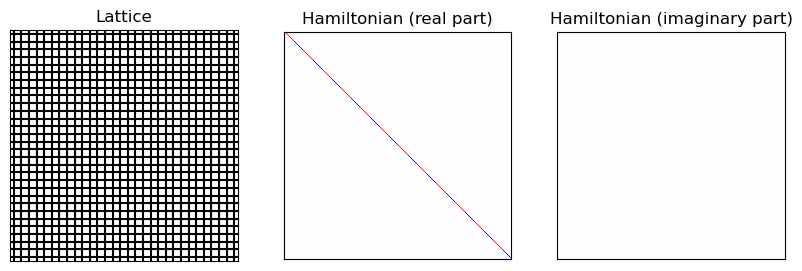

In [40]:
from koala import example_graphs as eg
from koala.voronization import generate_lattice
from koala import plotting as pl
from koala.lattice import Lattice

system_size = 30
w = 0.0


square_lat = eg.square_lattice(system_size, system_size)
params = {
    "A": 1,
    "B": 1,
    "Delta": 2,
    "alpha": -0.3,
    "ws_vals": (np.random.rand(square_lat.n_vertices) * 2 - 1) * w / 2,
    "wp_vals": (np.random.rand(square_lat.n_vertices) * 2 - 1) * w / 2,
}


hamiltonian = bhz_ham(square_lat, **params)


#### plotting ####
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
pl.plot_edges(square_lat, ax=ax[0])
ax[1].matshow(
    hamiltonian.real,
    cmap="bwr",
    clim=(-np.max(np.abs(hamiltonian.real)), np.max(np.abs(hamiltonian.real))),
)
ax[2].matshow(
    hamiltonian.imag,
    cmap="bwr",
    clim=(-np.max(np.abs(hamiltonian.real)), np.max(np.abs(hamiltonian.real))),
)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

ax[0].set_title("Lattice")
ax[1].set_title("Hamiltonian (real part)")
ax[2].set_title("Hamiltonian (imaginary part)")

plt.show()

Text(0.5, 1.0, 'Energy Spectrum')

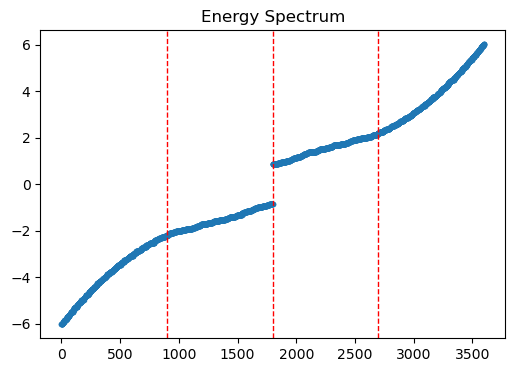

In [41]:
from scipy import linalg as la

e, v = la.eigh(hamiltonian)
full_proj = einsum("ik,k, jk -> ij", v, e < 0, v.conj())

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(e, ".")
ax.axvline(len(e) // 4, color="red", ls="--", linewidth=1)
ax.axvline(len(e) // 2, color="red", ls="--", linewidth=1)
ax.axvline(3 * len(e) // 4, color="red", ls="--", linewidth=1)

ax.set_title("Energy Spectrum")

In [42]:
x_vals = square_lat.vertices.positions[:, 0]
y_vals = square_lat.vertices.positions[:, 1]

spin_up = np.kron(
    np.ones(2),
    np.array([1, 0]),
)
spin_down = np.kron(
    np.ones(2),
    np.array([0, 1]),
)

su = np.kron(np.ones(square_lat.n_vertices), spin_up)
sd = np.kron(np.ones(square_lat.n_vertices), spin_down)

p_up = einsum("i,ij,j -> ij", su, full_proj, su)
p_down = einsum("i,ij,j -> ij", sd, full_proj, sd)

# make non-rotated chern numbers
c_up = chern_marker(square_lat, p_up, True)
c_down = chern_marker(square_lat, p_down, True)


# make a Hadamard rotation in spin space

hadamard = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
hadamard = np.kron(np.eye(2), hadamard)
hadamard = np.kron(np.eye(square_lat.n_vertices), hadamard)

p_up_hadamard = einsum("i,ij,jk,kl,l -> il", su, hadamard, full_proj, hadamard, su)
p_down_hadamard = einsum("i,ij,jk,kl,l-> il", su, hadamard, full_proj, hadamard, su)

c_up_hadamard = chern_marker(square_lat, p_up_hadamard, True)
c_down_hadamard = chern_marker(square_lat, p_down_hadamard, True)

Text(0.5, 1.0, ' Rotated Spin Bott nonsense')

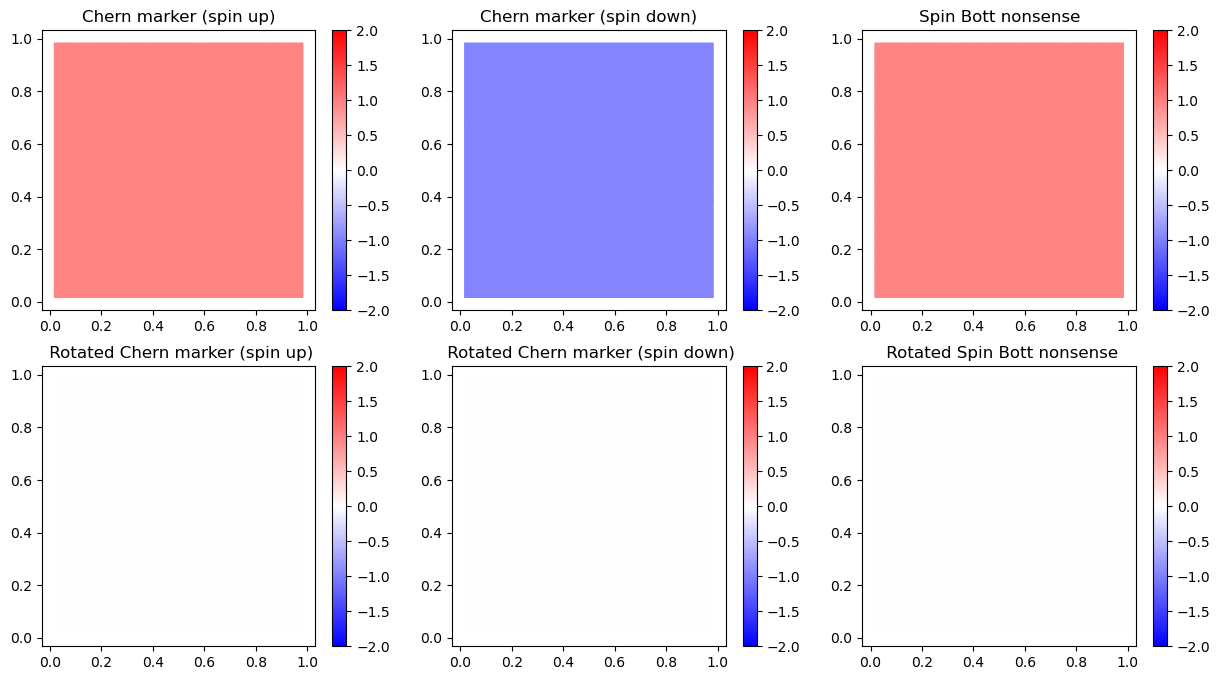

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

c1 = ax[0, 0].tripcolor(
    x_vals, y_vals, c_up, shading="gouraud", cmap="bwr", vmin=-2, vmax=2
)
c2 = ax[0, 1].tripcolor(
    x_vals, y_vals, c_down, shading="gouraud", cmap="bwr", vmin=-2, vmax=2
)
c3 = ax[0, 2].tripcolor(
    x_vals, y_vals, (c_up - c_down) / 2, shading="gouraud", cmap="bwr", vmin=-2, vmax=2
)

fig.colorbar(c1, ax=ax[0, 0])
fig.colorbar(c2, ax=ax[0, 1])
fig.colorbar(c3, ax=ax[0, 2])

ax[0, 0].set_title("Chern marker (spin up)")
ax[0, 1].set_title("Chern marker (spin down)")
ax[0, 2].set_title("Spin Bott nonsense")

c1_hadamard = ax[1, 0].tripcolor(
    x_vals, y_vals, c_up_hadamard, shading="gouraud", cmap="bwr", vmin=-2, vmax=2
)
c2_hadamard = ax[1, 1].tripcolor(
    x_vals, y_vals, c_down_hadamard, shading="gouraud", cmap="bwr", vmin=-2, vmax=2
)
c3_hadamard = ax[1, 2].tripcolor(
    x_vals,
    y_vals,
    (c_up_hadamard - c_down_hadamard) / 2,
    shading="gouraud",
    cmap="bwr",
    vmin=-2,
    vmax=2,
)

fig.colorbar(c1_hadamard, ax=ax[1, 0])
fig.colorbar(c2_hadamard, ax=ax[1, 1])
fig.colorbar(c3_hadamard, ax=ax[1, 2])

ax[1, 0].set_title(" Rotated Chern marker (spin up)")
ax[1, 1].set_title(" Rotated Chern marker (spin down)")
ax[1, 2].set_title(" Rotated Spin Bott nonsense")

In [44]:
sz_operator = np.kron(
    np.ones(square_lat.n_vertices), np.array([1, -1, 1, -1])
)  # Sz operator

rotated_sz = einsum("ji,j,jk -> ik", v.conj(), sz_operator, v)
ground_states = e < 0
sz_projected = rotated_sz[ground_states][:, ground_states]

sz_energies = la.eigvalsh(sz_projected)

Text(0.5, 1.0, 'Projected Sz eigenvalues')

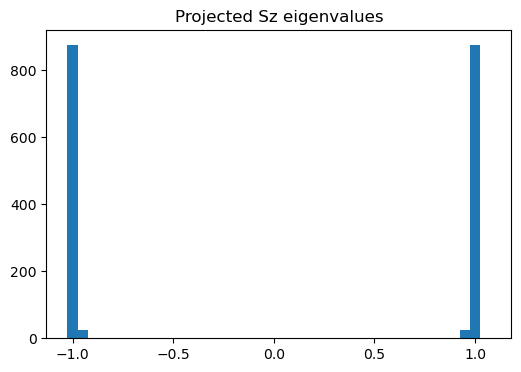

In [45]:
binsize = 0.05
range = np.max(np.abs(sz_energies))
bins = np.arange(-range - binsize, range + binsize, binsize) + binsize / 2

fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(sz_energies, bins=bins)
ax.set_title("Projected Sz eigenvalues")